In [264]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from pylab import rcParams

from sklearn.cluster import KMeans

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

import seaborn as sns

import base64 
from facets_overview.generic_feature_statistics_generator import GenericFeatureStatisticsGenerator
from IPython.core.display import display, HTML

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

# Import data as dataframe from movies.csv, tags.csv and ratings.csv

In [247]:
df_movies = pd.read_csv('../data/raw/movies.csv')
df_tags = pd.read_csv('../data/raw/tags.csv')
df_ratings = pd.read_csv('../data/raw/ratings.csv')

In [248]:
df_movies.head()
df_tags.head()
df_ratings.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


# View the stats of these datasets

In [249]:
df_movies.describe()
df_tags.describe()
df_ratings.describe()

,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


,userId,movieId,timestamp
count,3683.000000,3683.000000,3.683000e+03
mean,431.149335,27252.013576,1.320032e+09
std,158.472553,43490.558803,1.721025e+08
min,2.000000,1.000000,1.137179e+09
25%,424.000000,1262.500000,1.137521e+09
50%,474.000000,4454.000000,1.269833e+09
75%,477.000000,39263.000000,1.498457e+09
max,610.000000,193565.000000,1.537099e+09


,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


# Cleaning and Transformation
- I will check for the null values and based on the number of null values, will remove if they are less, otherwise look for other process.
- I will also remove the timestamp from rating and tag dataframe.
- The genre column has multiple genre for each movies. I will split the genre with '|' and then add new rows for these splits.
- Finally, I will merge the rating and tags using userid.

In [250]:
df_movies.genres = df_movies.genres.str.split('|')
df_movies = df_movies.explode('genres')
df_ratings.drop('timestamp', axis=1, inplace=True)
df_tags.drop('timestamp', axis=1, inplace=True)
df_movies.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure
0,1,Toy Story (1995),Animation
0,1,Toy Story (1995),Children
0,1,Toy Story (1995),Comedy
0,1,Toy Story (1995),Fantasy


In [251]:
df_movies.isna().sum()
df_ratings.isna().sum()
df_tags.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

userId     0
movieId    0
rating     0
dtype: int64

userId     0
movieId    0
tag        0
dtype: int64

In [252]:
df_new = pd.merge(df_ratings, df_tags ,on=['userId','movieId'],how='left')
df_new.describe()
df_new.isna().sum()

,userId,movieId,rating
count,102677.000000,102677.000000,102677.000000
mean,327.761933,19742.712623,3.514813
std,183.211289,35884.400990,1.043133
min,1.000000,1.000000,0.500000
25%,177.000000,1199.000000,3.000000
50%,328.000000,3005.000000,3.500000
75%,477.000000,8366.000000,4.000000
max,610.000000,193609.000000,5.000000


userId         0
movieId        0
rating         0
tag        99201
dtype: int64

# Number of nulls is large, so will replace all nulls with 'Others'.

In [253]:
df_new.fillna('Others', inplace=True)
df_new.isna().sum()

userId     0
movieId    0
rating     0
tag        0
dtype: int64

# Group the new dataframe by ratings 

In [254]:
ratings = df_new[['movieId', 'rating']].groupby('rating').count()
print(ratings)

        movieId
rating         
0.5        1373
1.0        2819
1.5        1801
2.0        7563
2.5        5568
3.0       20189
3.5       13424
4.0       27208
4.5        8811
5.0       13921


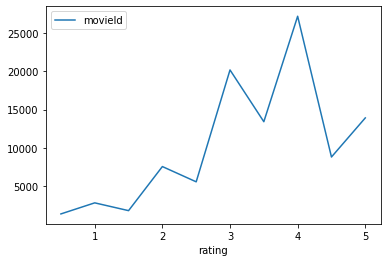

In [255]:
ratings.plot()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x130cc3a10>]],
      dtype=object)

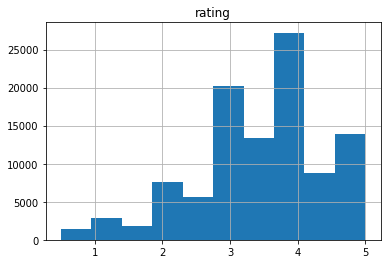

In [256]:
df_new.hist('rating')

- From this plot and the table above, we can find that the most of the movies were rated as 4.
- There were few users, who rate movies when they are bad.

# Blockbuster Movies
- Movies with the rating greater than 4.0 are assumed to be blockbuster.

In [257]:
blockbuster_movies = df_new['rating'] > 4.0
df_new[blockbuster_movies]

,userId,movieId,rating,tag
3,1,47,5.0,Others
4,1,50,5.0,Others
6,1,101,5.0,Others
8,1,151,5.0,Others
9,1,157,5.0,Others
...,...,...,...,...
102662,610,160527,4.5,Others
102670,610,164179,5.0,Others
102673,610,168248,5.0,Heroic Bloodshed
102674,610,168250,5.0,Others


- Based on the assumptions, there are 22732 movies which can be labeled blockbuster

# Art Movies
- Movie tags with 'art' is assumed to be art movies.

In [258]:
art_movies = df_new['tag'].str.lower().str.match('art')
art = (df_new[art_movies] == 'art')
count = art.tag.sum()
print(count)

2


/usr/local/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


- Number of tag containing 'art' is negligible, just 2.

- One hot encode feature 'tag'

In [259]:
one_hot = pd.get_dummies(df_new['tag'])
df_new = pd.concat([df_new, one_hot], axis = 1)
df_new = df_new.drop(['tag'], axis=1)
df_new.head()

,userId,movieId,rating,"""artsy""",06 Oscar Nominated Best Movie - Animation,1900s,1920s,1950s,1960s,1970s,...,women,wonderwoman,workplace,writing,wrongful imprisonment,wry,younger men,zither,zoe kazan,zombies
0,1,1,4.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,3,4.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,6,4.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,47,5.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,50,5.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# KMean Cluster
Use the Elbow method to find a good number of clusters using WCSS

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

array([1, 1, 1, ..., 3, 3, 3], dtype=int32)

array([1, 1, 1, ..., 2, 2, 2], dtype=int32)

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

array([0, 0, 0, ..., 5, 5, 5], dtype=int32)

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

array([6, 6, 6, ..., 2, 2, 2], dtype=int32)

array([ 0,  0,  0, ...,  4,  4, 11], dtype=int32)

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

Text(0.5, 1.0, 'Computing WCSS for KMeans++')

Text(0.5, 0, 'Number of clusters')

Text(0, 0.5, 'WCSS')

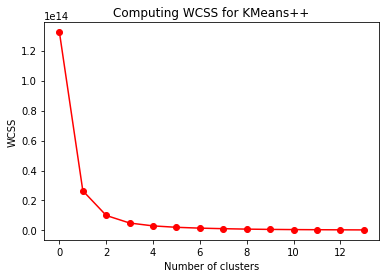

In [262]:
wcss = []
for ii in range( 1, 15 ):
    kmeans = KMeans(n_clusters=ii, init="k-means++", n_init=10, max_iter=300) 
    kmeans.fit_predict( df_new )
    wcss.append( kmeans.inertia_ )
    
plt.plot( wcss, 'ro-', label="WCSS")
plt.title("Computing WCSS for KMeans++")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

- I will be chosing cluster size of 5. 


In [ ]:
kmeans = KMeans(n_clusters=5, init="k-means++", n_init=10, max_iter=300) 
y_pred = kmeans.fit_predict( df_new )

# As it's difficult to visualise clusters when the data is high-dimensional - we'll see
# if Seaborn's pairplot can help us see how the clusters are separating out the samples.   
df_new["cluster"] = y_pred
cols = list(df_new.columns)

sns.pairplot( df_new[ cols ], hue="cluster")

# This cell took more than hour without returning any result.
- This might be because of large number of tags present in the data. Let us try with the movie and rating files.

# Trying with movies and ratings


In [322]:
df_movie_rate = pd.merge(df_movies, df_ratings ,on=['movieId'],how='left')
df_movie_rate.describe()
df_movie_rate.isna().sum()

,movieId,userId,rating
count,274518.000000,274480.000000,274480.000000
mean,20302.194515,324.707607,3.517797
std,35368.314597,182.550241,1.034705
min,1.000000,1.000000,0.500000
25%,1198.000000,177.000000,3.000000
50%,3037.500000,323.000000,3.500000
75%,8961.000000,477.000000,4.000000
max,193609.000000,610.000000,5.000000


movieId     0
title       0
genres      0
userId     38
rating     38
dtype: int64

- Since, the number of nulls are very less compared to the total count, I will drop them.

In [323]:
df_movie_rate = df_movie_rate.dropna()
df_movie_rate.isna().sum()

movieId    0
title      0
genres     0
userId     0
rating     0
dtype: int64

# Hist plot for combined dataframe

In [324]:
ratings_movie = df_movie_rate[['movieId', 'rating']].groupby('rating').count()
print(ratings_movie)

        movieId
rating         
0.5        3694
1.0        7156
1.5        4628
2.0       19890
2.5       14982
3.0       54292
3.5       36473
4.0       73030
4.5       23883
5.0       36452


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x174b570d0>]],
      dtype=object)

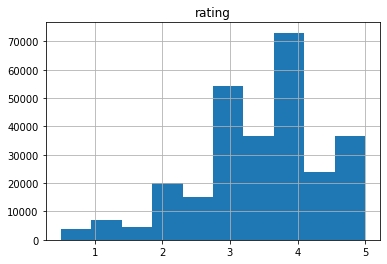

In [325]:
df_movie_rate.hist('rating')

- Basically this plot and the above plot is same, so we get same result. The number of movies with rating 4 is highest.

# One Hot encode genres.

In [326]:
label_encoder = LabelEncoder()
df_movie_rate = df_movie_rate.apply(label_encoder.fit_transform)
df_movie_rate.head()
df_movie_rate.describe()

,movieId,title,genres,userId,rating
0,0,8871,2,0,7
1,0,8871,2,4,7
2,0,8871,2,6,8
3,0,8871,2,14,4
4,0,8871,2,16,8


,movieId,title,genres,userId,rating
count,274480.000000,274480.000000,274480.000000,274480.000000,274480.000000
mean,3181.699909,4876.319921,8.394061,323.707607,6.035595
std,2662.213713,2786.152562,5.549587,182.550241,2.069410
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,899.000000,2482.750000,4.000000,176.000000,5.000000
50%,2288.000000,4895.500000,8.000000,322.000000,6.000000
75%,5363.000000,7406.000000,14.000000,476.000000,7.000000
max,9723.000000,9718.000000,19.000000,609.000000,9.000000


array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

array([2, 2, 2, ..., 1, 1, 1], dtype=int32)

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

array([1, 1, 1, ..., 2, 2, 2], dtype=int32)

array([5, 5, 5, ..., 0, 0, 0], dtype=int32)

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

array([3, 3, 3, ..., 2, 2, 2], dtype=int32)

array([7, 7, 7, ..., 3, 3, 3], dtype=int32)

array([4, 4, 4, ..., 2, 2, 2], dtype=int32)

array([3, 3, 3, ..., 4, 4, 4], dtype=int32)

array([7, 7, 7, ..., 6, 6, 6], dtype=int32)

array([2, 2, 2, ..., 7, 7, 7], dtype=int32)

array([9, 9, 9, ..., 5, 5, 5], dtype=int32)

array([5, 5, 5, ..., 9, 9, 9], dtype=int32)

array([ 8,  8,  8, ..., 15, 15, 15], dtype=int32)

array([9, 9, 9, ..., 7, 7, 7], dtype=int32)

array([1, 1, 1, ..., 8, 8, 8], dtype=int32)

array([11, 11, 11, ...,  3,  3,  3], dtype=int32)

array([ 8,  8,  8, ..., 14, 14, 14], dtype=int32)

array([ 0,  0,  0, ..., 19, 19,  6], dtype=int32)

array([2, 2, 2, ..., 6, 6, 6], dtype=int32)

array([18, 18, 18, ..., 19, 19, 19], dtype=int32)

array([20, 20, 20, ..., 22, 22, 22], dtype=int32)

array([ 0,  0,  0, ..., 17, 17, 17], dtype=int32)

array([ 8,  8,  8, ..., 15, 15, 15], dtype=int32)

array([19, 19, 19, ..., 24, 24, 24], dtype=int32)

array([12, 12, 12, ...,  6,  6,  6], dtype=int32)

array([ 9,  9,  9, ..., 17, 17, 17], dtype=int32)

Text(0.5, 1.0, 'Computing WCSS for KMeans++')

Text(0.5, 0, 'Number of clusters')

Text(0, 0.5, 'WCSS')

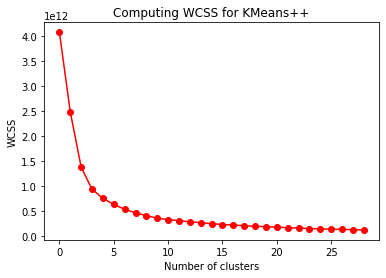

In [327]:
wcss = []
for ii in range( 1, 30 ):
    kmeans = KMeans(n_clusters=ii, init="k-means++", n_init=10, max_iter=300) 
    kmeans.fit_predict( df_movie_rate )
    wcss.append( kmeans.inertia_ )
    
plt.plot( wcss, 'ro-', label="WCSS")
plt.title("Computing WCSS for KMeans++")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

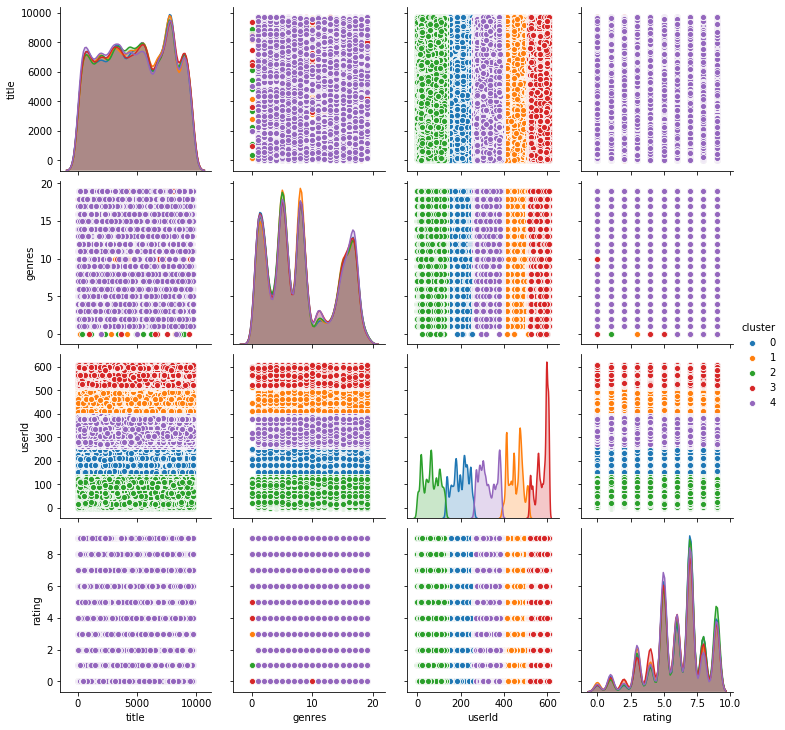

In [328]:
some_cols = ["title", "genres", "userId", "rating"]
kmeans = KMeans(n_clusters=5, init="k-means++", n_init=10, max_iter=300) 
some_vals = df_movie_rate[some_cols].iloc[ :, 1:].values
y_pred = kmeans.fit_predict( some_vals )

df_movie_rate["cluster"] = y_pred
some_cols.append("cluster")
sns.pairplot( df_movie_rate[ some_cols ], hue="cluster")